<a href="https://colab.research.google.com/github/BreakoutMentors/Data-Science-and-Machine-Learning/blob/main/machine_learning/lesson%204%20-%20ML%20Apps/Gradio/Intro_to_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Note: Always open in Colab for the best learning experience.

# Introduction to Transfer Learning

<img src="https://miro.medium.com/max/1000/0*xNjEPIZmPvKeqss6" width=600>

*Image is from an [article](https://medium.datadriveninvestor.com/introducing-transfer-learning-as-your-next-engine-to-drive-future-innovations-5e81a15bb567) by Data Driven Investor*

Transfer Learning is the process of using previously trained (pretrained) models that are very successful at finding features, then fine-tuning them for the purposes of our own datasets. This concept is mostly involved in both Computer Vision and Natural Language Processing. The benefits of using pretrained models is that they have been successful at finding features already, and do not need to be trained again that saves us a lot of time with being able to get state-of-the-art results. The term "*Transfer Learning*" comes from the idea of transferring the weights that do feature extraction from trained models, then using those feature extraction weights to extract features from a dataset that the original model did not train on.

To be more concrete, we will focus on what Transfer Learning means when working with CNN's. If you remember, there are two major parts to a Convolutional Neural Network: Convolutional Layers and Fully-Connected Layers. Convolutional Layers are responsible of extracting features from the images, while FC Layers are responsible of taking the features as input to produce predictions. All of the [pretrained models](https://pytorch.org/vision/stable/models.html#) have been trained on a dataset called [ImageNet](https://www.image-net.org/), that has 1,000 classes. These models perform very well at extracting features for the ImageNet dataset that contains a lot of classes, therefore the models are very good at finding features for many different objects. So if the Convolutional Layers work well at extracting features, there is no reason to retrain it! Now in this notebook, we will use the [Flowers Recognition](https://www.kaggle.com/alxmamaev/flowers-recognition) dataset. So if we have a new dataset that we want to use, we will change the FC Layers that are responsible for providing predictions.

Therefore, the process of Transfer Learning for CNNs is this:
1. Load dataset and transform the images
2. Split the dataset into training, validation, and test datasets
3. Load pretrained model and Freeze Parameters
4. Finetuning the Model
5. Train the new FC Layers with new images
6. Save Model to use later

## Loading the data from Kaggle

[Click here to access the dataset](https://www.kaggle.com/alxmamaev/flowers-recognition)

If you do not have an account with Kaggle, please make an account with them.

After making an account, you need to download a *kaggle.json* file on your local machine that provides the api to download the dataset.

To download this file follow the instructions below:
1. Click on your account in the top right
2. Click account settings
3. Scroll down to the 'API' section
4. Click 'Create New API Token' then it should download

The *kaggle.json* file is needed when it asks you to upload a file below before it downloads the dataset to this Colab.

In [ ]:
from google.colab import files
from IPython.utils import io
import os
files.upload()
os.system("mkdir -p ~/.kaggle")
os.system("cp kaggle.json ~/.kaggle/")
os.system("chmod 600 ~/.kaggle/kaggle.json")
!kaggle datasets download -d alxmamaev/flowers-recognition
with io.capture_output() as captured:
    !unzip flowers-recognition.zip && rm flowers-recognition.zip
    !rm -r /content/flowers/flowers

Saving kaggle.json to kaggle.json
 99% 445M/450M [00:09<00:00, 55.5MB/s]
100% 450M/450M [00:09<00:00, 48.9MB/s]


## Importing all the libraries needed

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms

%matplotlib inline

# Loading Data and Image Processing

Just as in the CNN lesson, we will be using [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder) dataset class to load our data.

Also, since we are using models that were trained on the ImageNet dataset, we need to process the images of our dataset to have the same transformations given to images in ImageNet.

The two transforms that are required is to resize the images to 224x224 sizes, and then to convert the images to torch tensors. We can also add more transformations like 
[`RandomRotation`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.RandomRotation) to add more variability to our input.

**It is important to know that the flower dataset we are using contain images of pixel dimensions of 320x240.**

In [ ]:
from torchvision.datasets import ImageFolder
root = "/content/flowers"

# ImageNet means and stds to normalize images in entire dataset
means = (0.485, 0.456, 0.406)
stds = (0.229, 0.224, 0.225)

ImageNet_Normalization = transforms.Normalize(means, stds)

transforms = torchvision.transforms.Compose([
                # Randomly rotating images between (-20, +20) degrees
                torchvision.transforms.RandomRotation(20),
                # Center Cropping the images with a 224x224 size
                torchvision.transforms.CenterCrop((224, 224)),
                # Converting the images to tensors
                torchvision.transforms.ToTensor(),
                # Normalizing data
                ImageNet_Normalization
])

dataset = ImageFolder(root, transform=transforms)

## Splitting the dataset

We need to now split the dataset to gather our training, validation, and test datasets. Then after we split them, we will use dataloaders to load the data in batches.

In [ ]:
# Calculating the amount of images to split the dataset
trainToTestRatio = 0.8
trainSize = int(trainToTestRatio * len(dataset))
testSize = len(dataset) - trainSize

# Calculating the amount to split the training set into validation set
valSize = int(trainSize * 0.1) # Taking 10% of training data
trainSize = trainSize - valSize # Updating the amount of training data

# Splitting Data
training_data, val_data, testing_data = torch.utils.data.random_split(dataset, lengths=[trainSize, valSize, testSize])

# Loading Data
batch_size = 64

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(testing_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

# Using dictionaries to easily access all the dataloaders and datasets
loaders = {'train':train_dataloader, 'valid':val_dataloader, 'test':test_dataloader}
datasets = {'train':training_data, 'valid':val_data, 'test':testing_data}

print("These are the classes:", dataset.class_to_idx)

These are the classes: {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


## Samples of Images

Here is a couple of images that have been processed, it is not important for you to know what the code is doing. However, please look at the images to understand how they have been processed.


Samples of Images:


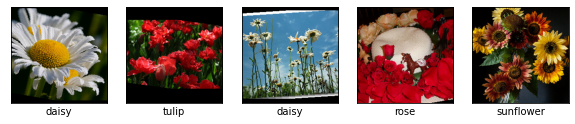

In [ ]:
import torchvision.transforms.functional as F
# Function to reverse normalization of the images
def unnormalize_tensor(tensor, means, stds):
    tensor_duplicate = tensor.detach().clone()
    for channel, mean, std in zip(tensor_duplicate, means, stds):
        channel.mul_(std).add_(mean)
    return tensor_duplicate

images, labels = next(iter(train_dataloader))

# Printing images and their labels
print("\nSamples of Images:")
idx_to_class = {value:key for key,value in dataset.class_to_idx.items()}
plt.figure(figsize=(10, 9))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = F.to_pil_image(unnormalize_tensor(images[i], means, stds))
    plt.imshow(image)
    plt.xlabel(idx_to_class[labels[i].item()])

# Loading Pretrained Model and Freezing Parameters

Since you are new pretrained models, I have included a pretrained [ResNet101](https://pytorch.org/vision/stable/models.html#torchvision.models.resnet101) model, if you want to change it please use another model. All of these models take 224x224 RGB images, so the images are already processed for it.

We will also be freezing the parameters inside the pretrained model, which means that they will not change when wanting to train the new fully-connected layers of our model after finetuning them.

In [ ]:
# Using pretrained resnet model; please use a different one if you would like
model = torchvision.models.resnet101(pretrained=True)

# Freezing all parameters, so they do not change
for param in model.parameters():
    param.requires_grad = False

print('Here are the layers of the model:')
model

Here are the layers of the model:


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Finetuning the Model

The Fully-Connected Layer is saved in the attribute `model.fc`, and we will change this layer to have the number of outputs for the number of classes we have. We will be using [`torch.nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) that provides a container to have multiple layers for the purpose of providing predictions. After you replace the fully-connected layers, the new layers you placed have their parameters not frozen, therefore only the parameters of the layers you put will train.

In [ ]:
print('This is the Fully-Connected Layer')
print(model.fc)
num_features = model.fc.in_features #
num_classes = len(dataset.class_to_idx)

# Replacing model.fc layer
model.fc = torch.nn.Sequential(
           nn.Linear(num_features, 512),
           nn.Linear(512, num_classes)
)

print('\nThis is the new Fully-Connected Layer after replacing')
print(model.fc)

print('\nOnce you replace some of the layers, they automatically require gradients')
print('These are the layers that require gradients:')
for name, param in model.named_parameters():
    if param.requires_grad == True:
        print(name)

This is the Fully-Connected Layer
Linear(in_features=2048, out_features=1000, bias=True)

This is the new Fully-Connected Layer after replacing
Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): Linear(in_features=512, out_features=5, bias=True)
)

Once you replace some of the layers, they automatically require gradients
These are the layers that require gradients:
fc.0.weight
fc.0.bias
fc.1.weight
fc.1.bias


## Training the model

Along with training the new fully-connected layers, we will be saving the model to a file called `saved_model.pt` everytime the validation loss decreases every epoch.

In [ ]:
# Moving model to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Defining Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Defining Loss Function
criterion = nn.CrossEntropyLoss()

In [ ]:
def train(n_epochs, loaders, datasets, model, optimizer, criterion, device, save_path):
    """returns trained model"""
    print("Starting Training...")
    # Initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    losses = []
    valid_losses = []
    for epoch in range(1, n_epochs+1):
        # Initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for images, labels in loaders['train']:
            # Move to GPU if available
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Calculating the output
            output = model(images)
            
            # Caluculating the Loss
            loss = criterion(output, labels)
            
            # Calculating the gradients
            loss.backward()
            
            # Performing Gradient Descent Step
            optimizer.step()
            
            # Saving the training loss
            train_loss += loss.data
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for images, labels in loaders['valid']:
            # Move to GPU if available
            images, labels = images.to(device), labels.to(device)
            
            # Getting the output
            output = model(images)
            
            # Calculating the Loss
            loss = criterion(output, labels)
            
            # Saving the validation loss
            valid_loss += loss.data

        # Averaging the losses
        train_loss /= len(datasets['train'])
        valid_loss /= len(datasets['valid'])

        # Appending the losses to plot afterwards
        losses.append(train_loss.item())
        valid_losses.append(valid_loss.item())
            
        # Print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss))
        
        # Save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Saving Model')
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model, and saved losses
    return model, np.array(losses), np.array(valid_losses)

In [ ]:
# Training the model
epochs = 10
model, losses, valid_losses = train(epochs,
                                    loaders,
                                    datasets,
                                    model,
                                    optimizer,
                                    criterion,
                                    device,
                                    'saved_model.pt')

Starting Training...
Epoch: 1 	Training Loss: 0.015089 	Validation Loss: 0.009859
Saving Model
Epoch: 2 	Training Loss: 0.008445 	Validation Loss: 0.007064
Saving Model
Epoch: 3 	Training Loss: 0.006770 	Validation Loss: 0.005874
Saving Model
Epoch: 4 	Training Loss: 0.006074 	Validation Loss: 0.005949
Epoch: 5 	Training Loss: 0.005693 	Validation Loss: 0.005429
Saving Model
Epoch: 6 	Training Loss: 0.005531 	Validation Loss: 0.005325
Saving Model
Epoch: 7 	Training Loss: 0.004989 	Validation Loss: 0.004519
Saving Model
Epoch: 8 	Training Loss: 0.004729 	Validation Loss: 0.004886
Epoch: 9 	Training Loss: 0.004665 	Validation Loss: 0.004820
Epoch: 10 	Training Loss: 0.004484 	Validation Loss: 0.004577


## Plotting Training and Validation Losses

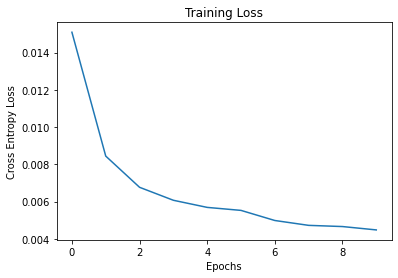

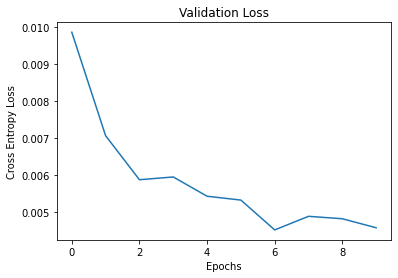

In [ ]:
def plot_losses(losses, title):
    plt.plot(losses)
    plt.xlabel("Epochs")
    plt.ylabel("Cross Entropy Loss")
    plt.title(title)
    plt.show()

plot_losses(losses, title='Training Loss')
plot_losses(valid_losses, title='Validation Loss')

## Evaluating the Model

In [ ]:
def getPredsFromLogits(logits):
    # Using softmax to get an array that sums to 1, and then getting the index with the highest value
    return torch.nn.functional.softmax(logits, dim=1).argmax(dim=1)

def test(loaders, model, criterion, device):

    # monitor test loss and accuracy
    test_loss = 0.0
    correct = 0
    total = 0

    model.eval()
    for images, labels in loaders['test']:
        # move to GPU if available
        images, labels = images.to(device), labels.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the loss
        loss = criterion(output, labels)
        # update average test loss 
        test_loss += loss.data
        # convert output probabilities to predicted class
        pred = getPredsFromLogits(output)
        # compare predictions to true label
        correct += pred.eq(labels).sum().item()
        total += pred.shape[0]
  
    test_loss /= total
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

test(loaders, model, criterion, device)

Test Loss: 0.004817


Test Accuracy: 89% (778/865)


## Downloading the Model

After downloading the model, you can use this model for an Image Classification App to predict flowers. We will be doing this in the next lesson!

In [ ]:
from google.colab import files

files.download('saved_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>